In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

import sim_lib.graph as graph
import sim_lib.graph_create as gc
import sim_lib.graph_networkx as gnx
import sim_lib.util as util

In [2]:
_N = 4
_NEW_VERTICES = 4

_ATTR_COUNT = 8
_ATTR_VALUE_COUNT = 2 ** (_N + _NEW_VERTICES)
_ZETA_DIST = np.random.zipf(2, _ATTR_VALUE_COUNT)
_ZETA_PROB = _ZETA_DIST / sum(_ZETA_DIST)

In [3]:
def pick_attr(vtx):
    return np.random.choice(list(range(_ATTR_VALUE_COUNT)),
                            _ATTR_COUNT, replace=False,
                            p=_ZETA_PROB)

In [4]:
# Time discounting
def time_discount(del_i):
    # Discount based on delta i, the number of iterations ago
    # this attribute was assigned
    return np.exp(del_i)

In [5]:
# Edge selection
def has_edge(u, v, G):
    attr_dict = G.data['total']
    total_surprise = 0
    
    if (not u in attr_dict) or (not v in attr_dict) or (v not in attr_dict[u]):
        return False
    
    for v, attr_time_dict in attr_dict[u].items():
        for attr, attr_time in attr_time_dict.items():
            print(u, v)
            print(attr_dict[u])
            print(attr_dict[v])
            print(G.data['cur'][u])
            print(G.data['cur'][v])
            asrt_msg = f"edge lifetime doesn't match {attr}, " + \
                f"{attr_dict[u][v][attr]}, {attr_dict[v][u][attr]}"
            assert attr_dict[u][v][attr] == attr_dict[v][u][attr], asrt_msg
            discount = time_discount(attr_time)
            total_surprise += - np.log2(_ZETA_PROB[attr] ** 2) / discount
            
    # tanh activation function
    return np.random.random() <= np.tanh(total_surprise)

In [6]:
def add_edge(u, v, G):
    assert (v in u.edges) == (u in v.edges), 'connection must be symmetric'
    if not G.are_neighbors(u, v):
        G.add_edge(u, v, 1)

# Graph creation
def attribute_block_graph(n):
    vtx_set = []
    cur_attr_dict = {}

    for i in range(n):
        vtx = graph.Vertex(0, 0, {0 : 0}, i)
        vtx.data = 0
        vtx_set.append(vtx)

    G = graph.Graph()
    G.vertices = vtx_set
    
    for vtx in G.vertices:
        cur_attr_dict[vtx] = pick_attr(vtx)
    
    G.data = {}
    G.data['cur'] = cur_attr_dict
    G.data['total'] = {} # Contains time since match for all attribute matches across time
    
    for u in G.vertices:
        for v in G.vertices:
            if u.vnum == v.vnum:
                continue
            for u_attr in cur_attr_dict[u]:
                if u_attr in cur_attr_dict[v]:
                    if u not in G.data['total']:
                        G.data['total'][u] = { v : { u_attr : 0 } }
                    elif v not in G.data['total'][u]:
                        G.data['total'][u][v] = { u_attr : 0 }
                    else:
                        G.data['total'][u][v][u_attr] = 0
                    
    for u in G.vertices:
        for v in G.vertices:
            if u.vnum == v.vnum:
                continue
            if not G.are_neighbors(u, v) and has_edge(u, v, G):
                add_edge(u, v, G)
    
    return G

In [7]:
# For adding to graph
def add_attr_graph_vtx(G, v):
    v.data = 0
    G.data['cur'][v] = pick_attr(v)

    G.vertices.append(v)
    return v

def update_attr_dim(G):
    
    # Pick new values
    for v in G.vertices:
        v.data += 1
        G.data['cur'][v] = pick_attr(v)
        
    # Modify attribute match times
    for v in G.vertices:
        for u in G.vertices:
            if u.vnum == v.vnum:
                continue
                
            # Add new attributes when shared
            for v_attr in G.data['cur'][v]:
                if v_attr in G.data['cur'][u]:
                    print(f"RESET {v} {u} ON {v_attr}")
                    if v not in G.data['total']:
                        G.data['total'][v] = { u : { v_attr : 0 } }
                    elif u not in G.data['total'][v]:
                        G.data['total'][v][u] = { v_attr : 0 }
                    else:
                        G.data['total'][v][u][v_attr] = 0
                
            # Update all no longer shared attributes amongst all attributes
            if not v in G.data['total']:
                continue
            if u in G.data['total'][v]:
                for all_attr in G.data['total'][v][u]:
                    if not all_attr in G.data['cur'][v]:
                        G.data['total'][v][u][all_attr] += 1
        
def recalc_edges(G):
    for uidx, u in enumerate(G.vertices):
        for vidx, v in enumerate(G.vertices):
            if uidx == vidx:
                continue
            if not G.are_neighbors(u, v) and has_edge(u, v, G):
                add_edge(u, v, G)
            elif G.are_neighbors(u, v) and not has_edge(u, v, G):
                G.remove_edge(u, v)

Vertex 0 Vertex 3
{Vertex 3: {69: 0}}
{Vertex 0: {69: 0}, Vertex 1: {182: 0}}
[194  45  70  91  69 204 247 178]
[ 98  69 182 191 119   0 248 249]
Vertex 1 Vertex 2
{Vertex 2: {94: 0, 173: 0}, Vertex 3: {182: 0}}
{Vertex 1: {173: 0, 94: 0}}
[ 94  18  36 193 182 174 173 139]
[173 141 161  94  24  12 217  81]
Vertex 1 Vertex 2
{Vertex 2: {94: 0, 173: 0}, Vertex 3: {182: 0}}
{Vertex 1: {173: 0, 94: 0}}
[ 94  18  36 193 182 174 173 139]
[173 141 161  94  24  12 217  81]
Vertex 1 Vertex 3
{Vertex 2: {94: 0, 173: 0}, Vertex 3: {182: 0}}
{Vertex 0: {69: 0}, Vertex 1: {182: 0}}
[ 94  18  36 193 182 174 173 139]
[ 98  69 182 191 119   0 248 249]
Vertex 1 Vertex 2
{Vertex 2: {94: 0, 173: 0}, Vertex 3: {182: 0}}
{Vertex 1: {173: 0, 94: 0}}
[ 94  18  36 193 182 174 173 139]
[173 141 161  94  24  12 217  81]
Vertex 1 Vertex 2
{Vertex 2: {94: 0, 173: 0}, Vertex 3: {182: 0}}
{Vertex 1: {173: 0, 94: 0}}
[ 94  18  36 193 182 174 173 139]
[173 141 161  94  24  12 217  81]
Vertex 1 Vertex 3
{Vertex 2: {94

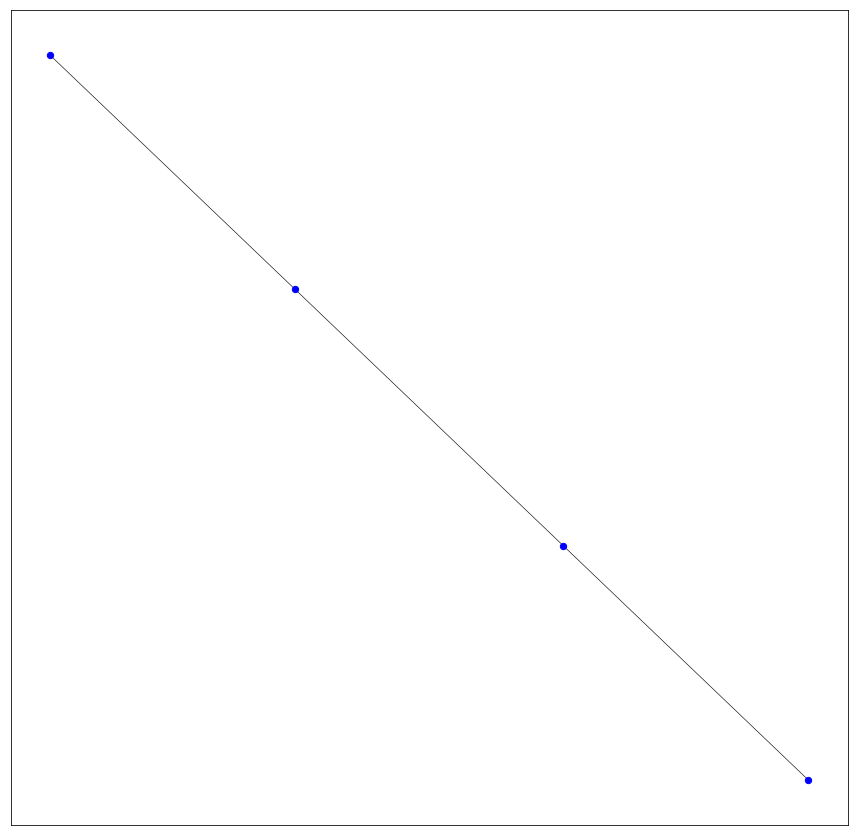

In [8]:
G_attr = attribute_block_graph(_N)

G_attr_nx = gnx.graph_to_nx(G_attr)
G_attr_vtx_pos = nx.drawing.layout.spring_layout(G_attr_nx)
plt.figure(figsize=(15,15))
nx.draw_networkx(G_attr_nx, pos=G_attr_vtx_pos, node_color='b',
                 node_size=40, width=0.6, with_labels=False)

def draw_graph(G_attr, nvtx):
    G_attr_nx = gnx.graph_to_nx(G_attr)
    G_attr_vtx_pos = nx.drawing.layout.spring_layout(G_attr_nx)
    
    prev_pos = G_attr_vtx_pos
    prev_nodes = G_attr_nx.nodes()
    
    # Get position of new vertex
    # Calculate positions as if all new, use this position for new vertex
    k_dist = 1 / (5 * np.sqrt(G_attr.num_people))
    G_attr_vtx_pos_recalc = nx.drawing.layout.spring_layout(G_attr_nx, k=k_dist)
    prev_pos[nvtx] = G_attr_vtx_pos_recalc[nvtx]
    
    nvtx_idx = list(G_attr_nx.nodes()).index(nvtx)
    colors = [ 'b' ] * len(G_attr.vertices)
    colors[nvtx_idx] = 'r'
    prev_pos = nx.drawing.layout.spring_layout(G_attr_nx)
    G_attr_vtx_pos = nx.drawing.layout.spring_layout(G_attr_nx,
                                                     pos=prev_pos, fixed=prev_nodes)
    
    # Draw graph
    plt.figure(figsize=(15,15))
    nx.draw_networkx(G_attr_nx, pos=G_attr_vtx_pos, node_color=colors,
                     node_size=40, width=0.6, with_labels=None)

In [9]:
for itr in range(_NEW_VERTICES):
    
    # Add vertex and add dimension to attributes
    nvtx = graph.Vertex(0, 0, {0 : 0}, _N + itr)
    
    # Order here is quite important
    add_attr_graph_vtx(G_attr, nvtx)
    update_attr_dim(G_attr)
    nvtx.data = 0
    recalc_edges(G_attr)
    
    draw_graph(G_attr, nvtx)

RESET Vertex 0 Vertex 1 ON 191
RESET Vertex 0 Vertex 1 ON 173
RESET Vertex 0 Vertex 4 ON 173
RESET Vertex 1 Vertex 0 ON 191
RESET Vertex 1 Vertex 0 ON 173
RESET Vertex 1 Vertex 2 ON 69
RESET Vertex 1 Vertex 3 ON 69
RESET Vertex 1 Vertex 4 ON 173
RESET Vertex 2 Vertex 1 ON 69
RESET Vertex 2 Vertex 3 ON 69
RESET Vertex 2 Vertex 3 ON 94
RESET Vertex 3 Vertex 1 ON 69
RESET Vertex 3 Vertex 2 ON 69
RESET Vertex 3 Vertex 2 ON 94
RESET Vertex 4 Vertex 0 ON 173
RESET Vertex 4 Vertex 1 ON 173
Vertex 0 Vertex 3
{Vertex 3: {69: 1}, Vertex 1: {191: 0, 173: 0}, Vertex 4: {173: 0}}
{Vertex 0: {69: 0}, Vertex 1: {182: 0, 69: 0}, Vertex 2: {69: 0, 94: 0}}
[174  76 191  90  38 209 173  33]
[141 249 182  69 146 187 127  94]


AssertionError: edge lifetime doesn't match 69, 1, 0